In [64]:
# This notebook can be used to analyze a model. ANY model. We are just going to 
# load this model on up, then run the validation data through it, and get make a nice confusion matrix
# from the results :)
#
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, model_from_json
from keras import backend as K 
from keras.layers import Dropout, Flatten, Dense

import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd



# You put the file names in here
#
json_file = 'VGG19_tansfer[m1]_2.json'
weight_file_name = 'VGG19_transfer[m1]_2.h5'
validation_dir = './cropped_split_dataset/validation'

# And you put the model architecture info here
#
loss = 'categorical_crossentropy'
num_units_first_dense = 1372
dropout_rate = 0.4662253413954879
num_units_second_dense = 1576
lr = 0.004454151354887021
momentum = 0.8802092606017858

####################################################
#       Where the magic happens                    #
#                                                  #  
model_json = open('./models_json/' + json_file, 'r')
loaded_model_json = model_json.read()
model_json.close()
model = model_from_json(loaded_model_json)
print('Model loaded from json...')

l = model.output
l = Flatten()(l)
l = Dense(num_units_first_dense, activation='relu')(l)
l = Dropout(dropout_rate)(l)
l = Dense(num_units_second_dense, activation='relu')(l)
final = Dense(2, activation='softmax')(l)
model = Model(inputs=model.input, outputs=final)
print('Extra layers of model added')

weight_file = './weights/' + weight_file_name
model.load_weights(weight_file)
print('Model weights loaded from disk...')

model.compile(
     loss=loss,
     optimizer=optimizers.SGD(lr=lr, momentum=momentum),
     metrics=['accuracy'])
print('Model Compiled')

model.summary()

Model loaded from json...
Extra layers of model added
Model weights loaded from disk...
Model Compiled
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_______________________________________

In [110]:
# Here is where we do the predictions and evaluations
#
img_height, img_width = 128, 128

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        shuffle=False,
        target_size=(img_height, img_width),
        class_mode='categorical')

predictions = model.predict_generator(validation_generator, use_multiprocessing=True)
evaluations = model.evaluate_generator(validation_generator, use_multiprocessing=True)


Found 11840 images belonging to 2 classes.


In [111]:
print('Performance of evaluation')
print(model.metrics_names)
print(evaluations)  # 97.3 accuracy Boiiiiii

Performance of evaluation
['loss', 'acc']
[0.07378142233738873, 0.9730574324324325]


(11840, 2)
[[1.00e+00 2.12e-07]
 [1.00e+00 3.62e-08]
 [5.57e-01 4.43e-01]
 [1.00e+00 2.12e-06]
 [1.00e+00 1.10e-08]]
[0 0 0 0 0]
[0 0 0 0 0]
Confusion matrix, without normalization
[[2677  114]
 [ 205 8844]]
Normalized confusion matrix
[[0.96 0.04]
 [0.02 0.98]]


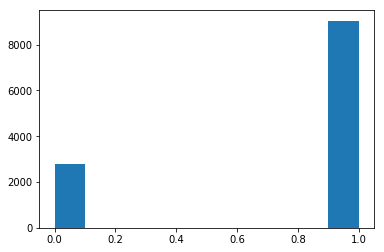

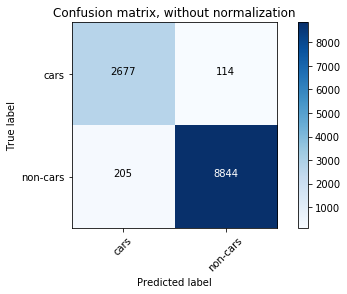

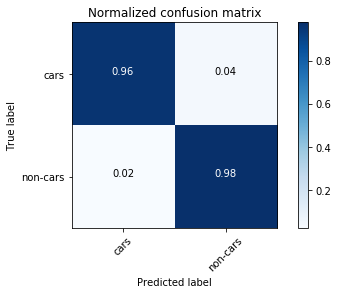

In [114]:
# Now to makea confusion matrix so that we can see some more precise 
# performance statistics
y_true = validation_generator.classes
y_pred = np.argmax(predictions, axis=-1)

# Compute confusion matrix
# Plot non-normalized  && normalized confusion matrices
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# Taken from scikit learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
